In [1]:
import os
import chess.pgn
from datetime import datetime

print('Preloading games...')
limit = 10000
games = []

for path in os.listdir("datasets"):
    with open(f'datasets/{path}') as file:
        while len(games) < limit:
            game = chess.pgn.read_game(file)
            if game is None:
                break

            date = game.headers.get('UTCDate')  # 2012.12.31
            time = game.headers.get('UTCTime')  # 23:04:12

            ts_game = {
                'id': game.headers.get('Site').split('/')[-1],  # [Site "https://lichess.org/j1dkb5dw"]
                'link': game.headers.get('Site'),
                'timestamp_utc': int(datetime.strptime(f'{date} {time}', '%Y.%m.%d %H:%M:%S').timestamp()),
                'event': game.headers.get('Event'),
                'white': game.headers.get('White'),
                'black': game.headers.get('Black'),
                'opening': game.headers.get('Opening'),
                'termination': game.headers.get('Termination'),
                'mainline_moves': str(game.mainline_moves()),
            }

            games.append(ts_game)
print('Loaded {} games'.format(len(games)))


def print_game(game):
    print(f"{game['white']} vs {game['black']} ({game['event']})")
    print(game['link'])
    print(game['mainline_moves'])
    print()

def make_markdown_table(array):
    nl = "\n"
    markdown = nl
    markdown += f"| {' | '.join(array[0])} |"
    markdown += nl
    markdown += f"| {' | '.join(['---']*len(array[0]))} |"
    markdown += nl
    for entry in array[1:]:
        markdown += f"| {' | '.join(map(lambda c: str(c), entry))} |{nl}"
    return markdown

# noinspection PyShadowingBuiltins
def human_size(bytes, units=None):
    minus = bytes < 0
    if minus:
        bytes = -bytes
    if units is None:
        units = [' bytes', 'KB', 'MB', 'GB', 'TB', 'PB', 'EB']
    formatted = str(bytes) + units[0] if bytes < 1024 or len(units) == 1 else human_size(bytes >> 10, units[1:])
    if minus:
        formatted = '-' + formatted
    return formatted

Preloading games...
Loaded 10000 games


In [5]:
# init solr
def create_index():
    requests.post("http://localhost:8983/api/collections", json={
        "create": {
            "name": "chess",
            "numShards": 1,
            "replicationFactor": 1
        }
    })

    requests.post("http://localhost:8983/api/collections/chess/schema", json={
        "add-field": [
            {"name": "link", "type": "string"},
            {"name": "timestampUtc", "type": "pint"},
            {"name": "event", "type": "string"},
            {"name": "white", "type": "string"},
            {"name": "black", "type": "string"},
            {"name": "whiteElo", "type": "pint"},
            {"name": "blackElo", "type": "pint"},
            {"name": "opening", "type": "string"},
            {"name": "moves", "type": "string"}
        ]
    })

# Typesense

In [85]:
import requests
import typesense
typesense_url = "http://localhost:8108"
typesense_api_key = "xyz"
typesense_api_key_header = "X-TYPESENSE-API-KEY"

typesense_client = typesense.Client({
    'nodes': [{
        'host': 'localhost',
        'port': '8108',
        'protocol': 'http'
    }],
    'api_key': 'xyz',
    'connection_timeout_seconds': 2
})

collection_name = 'chess'

measurements = []

def measure_metrics():
    measurement = requests.get(f"{typesense_url}/metrics.json",
                               headers={typesense_api_key_header: typesense_api_key}).json()

    measurement['system_cpu_active_percentage'] = float(measurement['system_cpu_active_percentage'])
    measurement['system_disk_used_bytes'] = int(measurement['system_disk_used_bytes'])
    measurement['system_memory_used_bytes'] = int(measurement['system_memory_used_bytes'])
    measurement['system_network_received_bytes'] = int(measurement['system_network_received_bytes'])
    measurement['system_network_sent_bytes'] = int(measurement['system_network_sent_bytes'])
    measurement['typesense_memory_active_bytes'] = int(measurement['typesense_memory_active_bytes'])
    measurement['typesense_memory_allocated_bytes'] = int(measurement['typesense_memory_allocated_bytes'])
    measurement['typesense_memory_mapped_bytes'] = int(measurement['typesense_memory_mapped_bytes'])
    measurement['typesense_memory_metadata_bytes'] = int(measurement['typesense_memory_metadata_bytes'])
    measurement['typesense_memory_fragmentation_ratio'] = float(measurement['typesense_memory_fragmentation_ratio'])
    measurement['typesense_memory_resident_bytes'] = int(measurement['typesense_memory_resident_bytes'])
    measurement['typesense_memory_retained_bytes'] = int(measurement['typesense_memory_retained_bytes'])
    measurements.append(measurement)
    return measurement


def subtract_measurements(m1, m2):
    m = {'system_cpu_active_percentage': m1['system_cpu_active_percentage'] - m2['system_cpu_active_percentage'],
         'system_disk_used_bytes': m1['system_disk_used_bytes'] - m2['system_disk_used_bytes'],
         'system_memory_used_bytes': m1['system_memory_used_bytes'] - m2['system_memory_used_bytes'],
         'system_network_received_bytes': m1['system_network_received_bytes'] - m2['system_network_received_bytes'],
         'system_network_sent_bytes': m1['system_network_sent_bytes'] - m2['system_network_sent_bytes'],
         'typesense_memory_active_bytes': m1['typesense_memory_active_bytes'] - m2['typesense_memory_active_bytes'],
         'typesense_memory_allocated_bytes': m1['typesense_memory_allocated_bytes'] - m2[
             'typesense_memory_allocated_bytes'],
         'typesense_memory_mapped_bytes': m1['typesense_memory_mapped_bytes'] - m2['typesense_memory_mapped_bytes'],
         'typesense_memory_metadata_bytes': m1['typesense_memory_metadata_bytes'] - m2[
             'typesense_memory_metadata_bytes'],
         'typesense_memory_fragmentation_ratio': m1['typesense_memory_fragmentation_ratio'] - m2[
             'typesense_memory_fragmentation_ratio'],
         'typesense_memory_resident_bytes': m1['typesense_memory_resident_bytes'] - m2[
             'typesense_memory_resident_bytes'],
         'typesense_memory_retained_bytes': m1['typesense_memory_retained_bytes'] - m2[
             'typesense_memory_retained_bytes']}

    return m


def display_metrics_text(measurement):
    print(f"CPU:                                  {measurement['system_cpu_active_percentage']}%")
    print(f"system_disk_used_bytes:               {human_size((measurement['system_disk_used_bytes']))}")
    print(f"system_memory_used_bytes:             {human_size((measurement['system_memory_used_bytes']))}")
    print(f"system_network_received_bytes:        {human_size((measurement['system_network_received_bytes']))}")
    print(f"system_network_sent_bytes:            {human_size((measurement['system_network_sent_bytes']))}")
    print(f"typesense_memory_active_bytes:        {human_size((measurement['typesense_memory_active_bytes']))}")
    print(f"typesense_memory_allocated_bytes:     {human_size((measurement['typesense_memory_allocated_bytes']))}")
    print(f"typesense_memory_mapped_bytes:        {human_size((measurement['typesense_memory_mapped_bytes']))}")
    print(f"typesense_memory_metadata_bytes:      {human_size((measurement['typesense_memory_metadata_bytes']))}")
    print(f"typesense_memory_fragmentation_ratio: {measurement['typesense_memory_fragmentation_ratio']}")
    print(f"typesense_memory_resident_bytes:      {human_size((measurement['typesense_memory_resident_bytes']))}")
    print(f"typesense_memory_retained_bytes:      {human_size((measurement['typesense_memory_retained_bytes']))}")

1. Średni czas przetwarzania zadania zawierającego 10000 dokumentów (porównanie bedzie się zaczynać na pustym indeksie)

In [86]:
print("Re/Creating collection...")
schema = {
    'name': collection_name,
    'fields': [
        {'name': 'link', 'type': 'string'},  # [Site "https://lichess.org/j1dkb5dw"]
        {'name': 'timestamp_utc', 'type': 'int32'},  # [UTCDate "2012.12.31"] [UTCTime "23:04:12"]
        {'name': 'event', 'type': 'string'},  # [Event "Rated Classical game"]
        {'name': 'white', 'type': 'string'},  # [White "BFG9k"]
        {'name': 'black', 'type': 'string'},  # [Black "mamalak"]
        {'name': 'opening', 'type': 'string'},  # [Opening "French Defense: Normal Variation"]
        {'name': 'termination', 'type': 'string'},  # [Termination "Normal"]
        {'name': 'mainline_moves', 'type': 'string'},  # 1. e4 e6 2. d4 b6 3. a3 Bb7 4. Nc3 Nh6 5. Bxh6 gxh6 6. Be2...
    ],
    'default_sorting_field': 'timestamp_utc'
}

names = [x['name'] for x in typesense_client.collections.retrieve()]

if collection_name in names:
    typesense_client.collections[collection_name].delete()

before = measure_metrics()

Re/Creating collection...


In [87]:
%%timeit

names = [x['name'] for x in typesense_client.collections.retrieve()]

if collection_name in names:
    typesense_client.collections[collection_name].delete()

typesense_client.collections.create(schema)

collection = typesense_client.collections[collection_name]

collection.documents.import_(games, {
    'action': 'upsert',
})

741 ms ± 27.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [88]:
after = measure_metrics()

2. Czas odpowiedzi na pojedyncze zapytania

In [89]:
query = "1. e4 e5 2. Nf3 Nc6 3. Bb5"
print("Searching for '{}'...".format(query))
params = {
    'q': query,
    'query_by': 'mainline_moves',
    'sort_by': 'timestamp_utc:desc',
    'per_page': 10,
    'page': 1,
}

Searching for 'e4 e5 Nf3 Nc6 Bb5 a6 Ba4 Nf6 O-O Be7 Re1 b5 Bb3 O-O c3 d5'...


In [90]:
%%timeit
results = collection.documents.search(params)

5.73 ms ± 400 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


3. Porównanie wyników wyszukiwania dla jednakowych zapytań

In [91]:
for result in results['hits']:
    print_game(result['document'])

german11 vs MihaSAH (Rated Blitz game)
https://lichess.org/oiy4rj23
1. e4 e5 2. Nf3 Nc6 3. Bb5 d6 4. h3 a6 5. Ba4 Nf6 6. d3 Be7 7. Bg5 Be6 8. O-O O-O 9. c3 b5 10. Bc2 h6 11. Bh4 Nh7 12. d4 Bxh4 13. d5 Bxd5 14. exd5 Na7 15. Qd3 f5 16. Re1 e4 17. Qd4 exf3 18. Re6 fxg2 19. Rg6 Bf6 20. Qf4 Bg5 21. Rxg5 Qxg5 22. Qf3 Rae8 23. Qg3 Nc8 24. Kxg2 Ne7 25. Qxg5 hxg5 26. Nd2 Nxd5 27. Nf3 Re2 28. Bb3 c6 29. Rd1 Kh8 30. Ng1 Rxb2 31. Nf3 Nf4+ 32. Kf1 d5 33. Ne5 a5 34. Nxc6 a4 35. Bxd5 Nxd5 36. Rxd5 Rxa2 37. Rxb5 Rc2 38. Rc5 a3 39. Nb4 Rb2 40. Ra5 Rb3 41. Nc2 Rxc3 42. Nxa3 Rc1+ 43. Kg2 Ra1 44. Nc4 Rxa5 45. Nxa5 Nf6 46. Nc6 Re8 47. Nd4 g6 48. Nf3 g4 49. hxg4 Nxg4 50. Kg3 Re2 51. Nh4 Kg7 52. f3 Nf6 53. Kf4 Kh6 54. Kg3 Nh5+ 55. Kh3 Re3 56. Kg2 Ra3 57. Kf2 Kg5 58. Ng2 f4 59. Ne1 Ra2+ 60. Kf1 Ng3+ 61. Kg1 Ra1 62. Kf2 Rxe1 63. Kxe1 Kf5 64. Kf2 g5 65. Kg2 Ne2 66. Kh3 Nd4 67. Kg2 Kg6 68. Kf2 Kh5 69. Kg2 Kh4 70. Kf2 Kh3 71. Kg1 Kg3 72. Kh1 Kxf3 73. Kg1 g4 74. Kh1 g3 75. Kg1 Kg4 76. Kh1 f3 77. Kg1 Kh3 78. Kh1 g2

4. Zużycie procesora i RAMu w momencie przetwarzania zadania zawierającego 10000 dokumentów

In [92]:
print("BEFORE")
display_metrics_text(before)
print()

print("AFTER")
display_metrics_text(after)
print()

print("DIFF")
display_metrics_text(subtract_measurements(after, before))

BEFORE
CPU:                                  2.44%
system_disk_used_bytes:               158GB
system_memory_used_bytes:             1GB
system_network_received_bytes:        367MB
system_network_sent_bytes:            174MB
typesense_memory_active_bytes:        72MB
typesense_memory_allocated_bytes:     48MB
typesense_memory_mapped_bytes:        127MB
typesense_memory_metadata_bytes:      20MB
typesense_memory_fragmentation_ratio: 0.32
typesense_memory_resident_bytes:      72MB
typesense_memory_retained_bytes:      909MB

AFTER
CPU:                                  0.0%
system_disk_used_bytes:               158GB
system_memory_used_bytes:             1GB
system_network_received_bytes:        417MB
system_network_sent_bytes:            175MB
typesense_memory_active_bytes:        82MB
typesense_memory_allocated_bytes:     60MB
typesense_memory_mapped_bytes:        325MB
typesense_memory_metadata_bytes:      20MB
typesense_memory_fragmentation_ratio: 0.27
typesense_memory_resident_bytes:

5. Średni czas odpowiedzi pzry wielu jednoczesnych wyszukiwaniach - analiza przeprowadzona będzie na jednej maszynie, przy użyciu jednego skryptu wysyłajacego zapytania HTTP aby zminimalizować wpływ innych czynników niz silnik

In [93]:
import requests
from timeit import default_timer as timer
from concurrent.futures import ThreadPoolExecutor

def query(n):
    start = timer()
    collection.documents.search(params)
    end = timer()
    return end - start

with ThreadPoolExecutor(max_workers=10000) as pool:
    r = list(pool.map(query,range(10000)))
    print(f"Average time: {sum(r)/len(r):.2f} seconds")

Average time: 0.20 seconds


6. Wzrost wielkości indeksu w zależnosci od ilości zaindeksowanch dokumentów

Indexing batch 1...
Indexing batch 2...
Indexing batch 3...
Indexing batch 4...
Indexing batch 5...
Indexing batch 6...
Indexing batch 7...
Indexing batch 8...
Indexing batch 9...
Indexing batch 10...


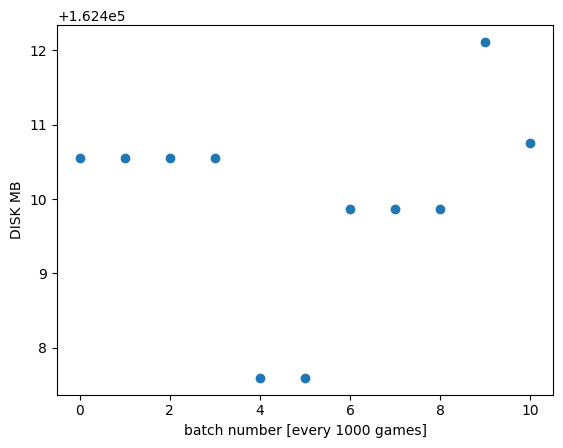

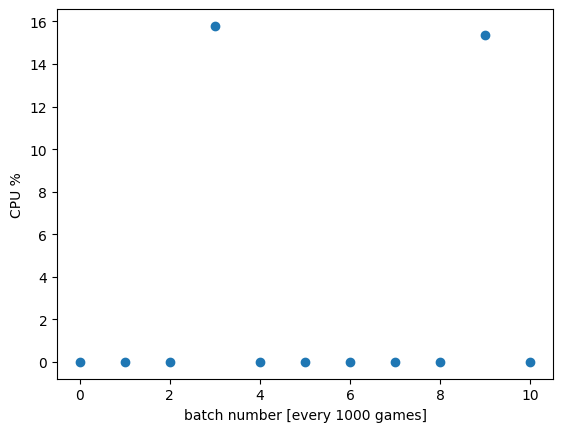

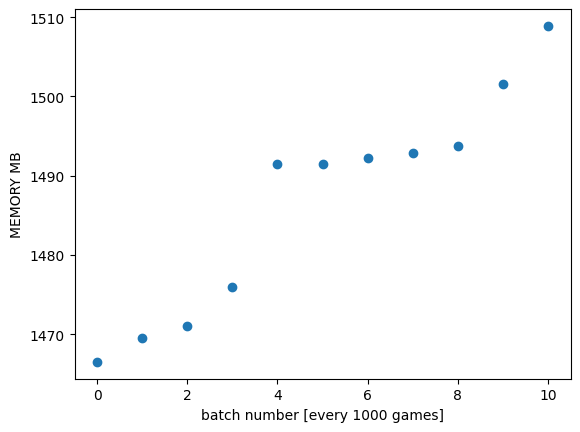

In [95]:
import matplotlib.pyplot as plt

batch_size = 1000

def plot(data, name):
    x = [i for i, _ in enumerate(data)]
    y = data

    plt.xlabel(f'batch number [every {batch_size} games]')
    plt.ylabel(name)
    plt.scatter(x, y)
    plt.show()


def plot_metric(metric, name, transform=lambda x: x):
    plot([transform(measurement[metric]) for measurement in measurements], name)

measurements.clear()

names = [x['name'] for x in typesense_client.collections.retrieve()]

if collection_name in names:
    typesense_client.collections[collection_name].delete()

typesense_client.collections.create(schema)

collection = typesense_client.collections[collection_name]

measure_metrics()
for i in range(0, len(games), batch_size):
    print(f"Indexing batch {i // batch_size + 1}...")
    collection.documents.import_(games[i:i+batch_size], {
        'action': 'upsert',
    })
    measure_metrics()

plot_metric("system_disk_used_bytes", "DISK MB", lambda x: float(x) / 1024.0 / 1024.0)
plot_metric("system_cpu_active_percentage", "CPU %", lambda x: float(x))
plot_metric("system_memory_used_bytes", "MEMORY MB", lambda x: float(x) / 1024.0 / 1024.0)

7. Porównanie wsparcia da popularnych jezyków programowania oraz próba określenia łatwości korzystania z dokumentacji i jej kompletności

# Elasticsearch

In [2]:
from IPython.core.display import Markdown
from elasticsearch import Elasticsearch
from elasticsearch.helpers import bulk
import requests

elasticsearch_url = "http://localhost:9200"
elasticsearch_client = Elasticsearch(elasticsearch_url)
collection_name = 'chess'

def get_es_stats(description):
    node_name = list(elasticsearch_client.nodes.stats()["nodes"].keys())[0]
    stats = elasticsearch_client.nodes.stats(node_id=node_name)["nodes"][node_name]
    measures = {}
    measures["Description"] = description
    measures["CPU"] = stats['os']['cpu']['percent']
    measures["Disk used"] = stats["fs"]["total"]["total_in_bytes"] - stats["fs"]["total"]["free_in_bytes"]
    measures["Memory usage (total)"] = stats["os"]["mem"]["used_in_bytes"]
    measures["Memory usage (jvm)"] = stats["jvm"]["mem"]["heap_used_in_bytes"] + stats["jvm"]["mem"]["non_heap_used_in_bytes"]
    measures["Documents"] = stats["indices"]["docs"]["count"]
    measures["Store size"] = stats["indices"]["store"]["size_in_bytes"]
    if elasticsearch_client.indices.get(index=collection_name, ignore_unavailable=True) == {}:
        measures[f"Index \"{collection_name}\" store size"] = 0
    else:
        measures[f"Index \"{collection_name}\" store size"] = elasticsearch_client.indices.disk_usage(index=collection_name, run_expensive_tasks=True)["chess"]["store_size_in_bytes"]
    return measures

def get_values_differences(d1, d2):
    results = {}
    if d1.keys() == d2.keys():
        for key in d1:
            if isinstance(d1[key], (int, float, complex)) and isinstance(d1[key], (int, float, complex)):
                results[key] = d1[key] - d2[key]
            else:
                results[key] = d1[key]
    return results

def print_stats_list(stats_dictionaries):
    units = [' bytes', 'KB', 'MB']
    rows = [stats_dictionaries[0].keys()]
    for dictionary in stats_dictionaries:
        values = list(dictionary.values())
        rows.append([values[0], f"{values[1]}%", f"{ human_size(values[2], units)}", f"{ human_size(values[3], units)}", f"{ human_size(values[4], units)}", values[5], f"{ human_size(values[6], units)}", f"{human_size(values[7], units)}"])
    display(Markdown(make_markdown_table(rows)))

1. Średni czas przetwarzania zadania zawierającego 10000 dokumentów (porównanie bedzie się zaczynać na pustym indeksie)


In [3]:
print("Re/Creating collection...")
schema = {
    "mappings": {
        "properties": {
            "link": {"type": "text"},  # [Site "https://lichess.org/j1dkb5dw"]
            "timestamp_utc": {"type": "integer"},  # [UTCDate "2012.12.31"] [UTCTime "23:04:12"]
            "event": {"type": "text"},  # [Event "Rated Classical game"]
            "white": {"type": "text"},  # [White "BFG9k"]
            "black": {"type": "text"},  # [Black "mamalak"]
            "opening": {"type": "text"},  # [Opening "French Defense: Normal Variation"]
            "termination": {"type": "text"},  # [Termination "Normal"]
            "mainline_moves": {"type": "text"}  # 1. e4 e6 2. d4 b6 3. a3 Bb7 4. Nc3 Nh6 5. Bxh6 gxh6 6. Be2...
        }
    }
}
elasticsearch_client.indices.delete(index=collection_name,ignore_unavailable=True)
before = get_es_stats("Before")

Re/Creating collection...


In [4]:
%%timeit
elasticsearch_client.indices.delete(index=collection_name,ignore_unavailable=True)
elasticsearch_client.indices.create(index=collection_name,body=schema)
bulk(client=elasticsearch_client, index=collection_name, actions=games)
elasticsearch_client.indices.flush(index=collection_name)

<magic-timeit>:2: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.


1.21 s ± 42.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
after = get_es_stats("After")

2. Czas odpowiedzi na pojedyncze zapytania

In [6]:
query = "e4 e5 Nf3 Nc6 Bb5 a6 Ba4 Nf6 O-O Be7 Re1 b5 Bb3 O-O c3 d5"
print("Searching for '{}'...".format(query))
params = {
    "match": {
        "mainline_moves": {
            "query": query
        }
    }
}

Searching for 'e4 e5 Nf3 Nc6 Bb5 a6 Ba4 Nf6 O-O Be7 Re1 b5 Bb3 O-O c3 d5'...


In [7]:
%%timeit
results = elasticsearch_client.search(index=collection_name,query=params, sort={"timestamp_utc": {"order": "desc"}}, size=10)

4.43 ms ± 866 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


3. Porównanie wyników wyszukiwania dla jednakowych zapytań

In [8]:
results = elasticsearch_client.search(index=collection_name,query=params, sort={"timestamp_utc": {"order": "desc"}}, size=10)
for result in results["hits"]["hits"]:
    print_game(result["_source"])

ChikiPuki vs Pringao28 (Rated Bullet game)
https://lichess.org/osugph38
1. e4 e6 2. Bc4 b6 3. d4 Bb7 4. d5 exd5 5. exd5 Qe7+ 6. Ne2 c6 7. O-O cxd5 8. Bb5 Nc6 9. Re1 Nf6 10. Bxc6 dxc6 11. Nd4 O-O-O 12. Rxe7 Bxe7 13. Qe1 Rhe8 14. Bg5 h6 15. Bxf6 Bxf6 16. Qd2 c5 17. Nb5 Bg5 18. Qc3 d4 19. Qd2 Bxd2 20. Nxd2 Kb8 21. Na3 Ba6 22. Nac4 Bxc4 23. Nxc4 d3 24. cxd3 Rxd3 25. Ne3 Red8 26. g3 f6 27. b3 g6 28. Re1 f5 29. Nc4 Kb7 30. Nb2 Rd2 31. Nc4 Rxa2 32. h4 g5 33. Kg2 gxh4 34. gxh4 h5 35. Ne5 Rg8+ 36. Kh3 Rxf2 37. Nf7 Rfg2 38. Nh6 R8g3#

CrazyBullet vs Paker (Rated Bullet game)
https://lichess.org/rb1lnek9
1. e3 b6 2. d3 c5 3. f3 Bb7 4. e4 d5 5. e5 f6 6. exf6 Nxf6 7. Qe2 Qd6 8. Bg5 e5 9. Bxf6 gxf6 10. Nc3 Bh6 11. Nb5 Qc6 12. a4 a6 13. Nc3

pronik vs elenin012 (Rated Classical game)
https://lichess.org/7s6f3zgm
1. d4 d5 2. Nf3 Bf5 3. Bd2 e6 4. Nc3 Bd6 5. e3 Ne7 6. Be2 h6 7. O-O c6 8. a3 Bc7 9. h3 Qd6 10. Bd3 Bg6 11. Ne5 Nd7 12. f4 Nf5 13. Ne2 O-O 14. c4 dxc4 15. Bxc4 b5 16. Bd3 a5 17. Nxg6 fxg6 18. 

4. Zużycie procesora i RAMu w momencie przetwarzania zadania zawierającego 10000 dokumentów

In [9]:
difference = get_values_differences(after, before)
difference["Description"] = "Difference"
print_stats_list([before, after, difference])


| Description | CPU | Disk used | Memory usage (total) | Memory usage (jvm) | Documents | Store size | Index "chess" store size |
| --- | --- | --- | --- | --- | --- | --- | --- |
| Before | 0% | 39847MB | 15460MB | 7257MB | 42 | 40MB | 0 bytes |
| After | 6% | 39853MB | 15470MB | 1416MB | 10042 | 45MB | 5MB |
| Difference | 6% | 5MB | 10MB | -5841MB | 10000 | 5MB | 5MB |


5. Średni czas odpowiedzi pzry wielu jednoczesnych wyszukiwaniach - analiza przeprowadzona będzie na jednej maszynie, przy użyciu jednego skryptu wysyłajacego zapytania HTTP aby zminimalizować wpływ innych czynników niz silnik

In [10]:
from timeit import default_timer as timer
from concurrent.futures import ThreadPoolExecutor

def query(n):
    start = timer()
    elasticsearch_client.search(index=collection_name,query=params, sort={"timestamp_utc": {"order": "desc"}}, size=10)
    end = timer()
    return end - start

with ThreadPoolExecutor(max_workers=10000) as pool:
    r = list(pool.map(query,range(10000)))
    print(f"Average time: {sum(r)/len(r):.2f} seconds")

Average time: 2.77 seconds


6. Wzrost wielkości indeksu w zależnosci od ilości zaindeksowanch dokumentów

C:\Users\kbaci\AppData\Local\Temp\ipykernel_38128\594039527.py:19: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  elasticsearch_client.indices.create(index=collection_name,body=schema)


Indexing batch 1...
Indexing batch 2...
Indexing batch 3...
Indexing batch 4...
Indexing batch 5...
Indexing batch 6...
Indexing batch 7...
Indexing batch 8...
Indexing batch 9...
Indexing batch 10...


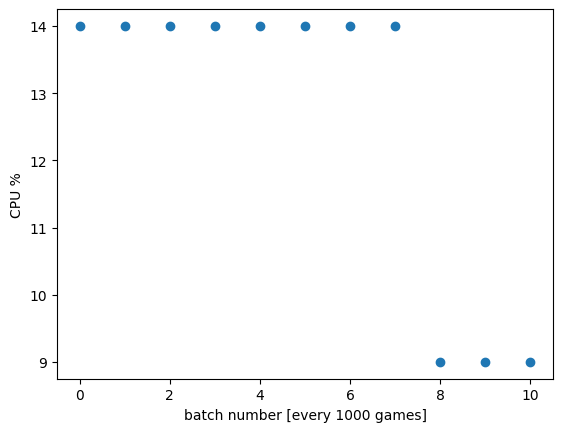

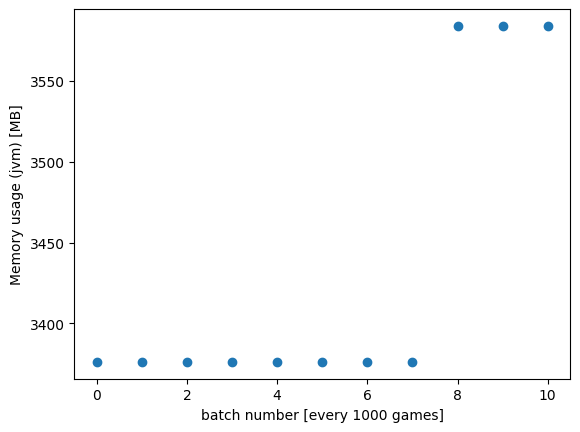

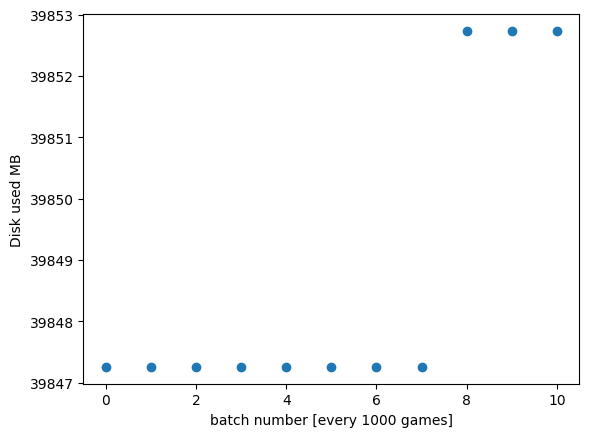

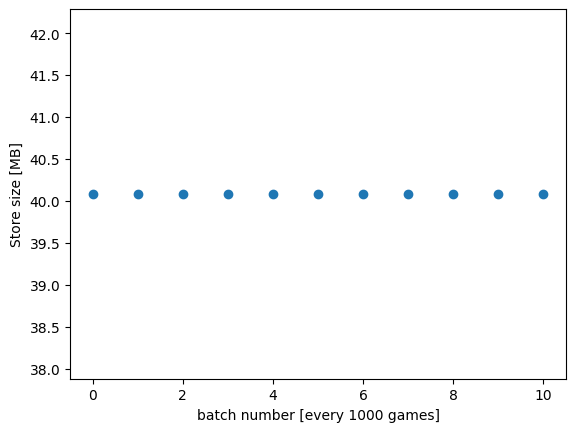

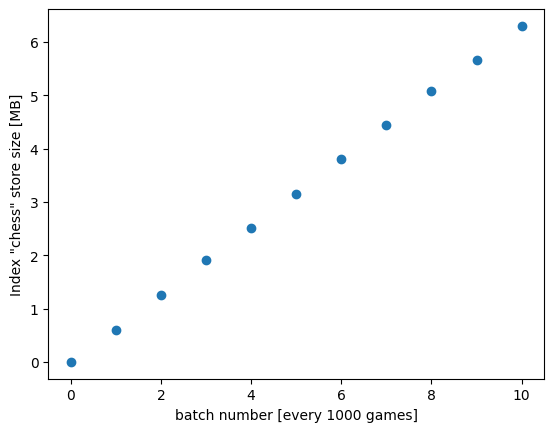

In [11]:
import matplotlib.pyplot as plt

batch_size = 1000

def plot(data, name):
    x = [i for i, _ in enumerate(data)]
    y = data

    plt.xlabel(f'batch number [every {batch_size} games]')
    plt.ylabel(name)
    plt.scatter(x, y)
    plt.show()


def plot_metric(metric, name, transform=lambda x: x):
    plot([transform(measurement[metric]) for measurement in measurements], name)

elasticsearch_client.indices.delete(index=collection_name,ignore_unavailable=True)
elasticsearch_client.indices.create(index=collection_name,body=schema)

measurements = [get_es_stats("before")]

for i in range(0, len(games), batch_size):
    print(f"Indexing batch {i // batch_size + 1}...")
    bulk(client=elasticsearch_client, index=collection_name, actions=games[i:i+batch_size])
    measurements.append(get_es_stats(f"after {i // batch_size + 1} batch"))

plot_metric("CPU", "CPU %", lambda x: float(x))
plot_metric("Memory usage (jvm)", "Memory usage (jvm) [MB]", lambda x: float(x) / 1024.0 / 1024.0)
plot_metric("Disk used", "Disk used MB", lambda x: float(x) / 1024.0 / 1024.0)
plot_metric("Store size", "Store size [MB]", lambda x: x / 1024.0 / 1024.0)
plot_metric(f"Index \"{collection_name}\" store size", f"Index \"{collection_name}\" store size [MB]", lambda x: x / 1024.0 / 1024.0)

# Solr

In [15]:
# Init solr

import requests
from timeit import default_timer as timer
from concurrent.futures import ThreadPoolExecutor
import chess.pgn
from datetime import datetime

def query(n):
    start = timer()
    moves = '"1. e4 e5 2. Nf3 Nc6 3. Bb5"'
    requests.get(f"http://localhost:8983/solr/chess/query?q=moves:{moves}&sort=timestampUtc%20desc")
    end = timer()
    return end - start


def create_index():
    requests.post("http://localhost:8983/api/collections", json={
        "create": {
            "name": "chess",
            "numShards": 1,
            "replicationFactor": 1
        }
    })

    requests.post("http://localhost:8983/api/collections/chess/schema", json={
        "add-field": [
            {"name": "link", "type": "string"},
            {"name": "timestampUtc", "type": "pint"},
            {"name": "event", "type": "string"},
            {"name": "white", "type": "string"},
            {"name": "black", "type": "string"},
            {"name": "whiteElo", "type": "pint"},
            {"name": "blackElo", "type": "pint"},
            {"name": "opening", "type": "string"},
            {"name": "moves", "type": "string"}
        ]
    })


def get_10000():
    with open("./datasets/lichess_db_standard_rated_2013-01.pgn") as file:
        docs = []
        while True:
            game = chess.pgn.read_game(file)

            if len(docs) == 10000:
                return docs

            date = game.headers.get('UTCDate')  # 2012.12.31
            time = game.headers.get('UTCTime')  # 23:04:12
            white_elo = game.headers.get('WhiteElo')
            black_elo = game.headers.get('BlackElo')

            game = {
                'id': game.headers.get('Site').split('/')[-1],  # [Site "https://lichess.org/j1dkb5dw"]
                'link': game.headers.get('Site'),
                'timestampUtc': int(datetime.strptime(f'{date} {time}', '%Y.%m.%d %H:%M:%S').timestamp()),
                'event': game.headers.get('Event'),
                'white': game.headers.get('White'),
                'black': game.headers.get('Black'),
                'whiteElo': int(white_elo) if white_elo != "?" else 0,
                'blackElo': int(black_elo) if black_elo != "?" else 0,
                'opening': game.headers.get('Opening'),
                'moves': str(game.mainline_moves())
            }

            docs.append(game)


def test_10000(docs):
    requests.post("http://localhost:8983/api/collections/chess/update?commit=true", json=docs)

create_index()
docs_bulk = get_10000()

1. Średni czas przetwarzania zadania zawierającego 10000 dokumentów (porównanie bedzie się zaczynać na pustym indeksie)

In [16]:
%%timeit

test_10000(docs_bulk)

790 ms ± 122 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


2. Czas odpowiedzi na pojedyncze zapytania

In [13]:
%%timeit

query(1)

6.87 ms ± 511 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


3. Porównanie wyników wyszukiwania dla jednakowych zapytań

In [24]:
import json
moves = '"1. e4 e5 2. Nf3 Nc6 3. Bb5"'
response = json.loads(requests.get(f"http://localhost:8983/solr/chess/query?q=moves:{moves}&sort=timestampUtc%20desc").content.decode("utf-8"))
print(*response["response"]["docs"], sep="\n\n")

{'id': '5srvvrok', 'link': 'https://lichess.org/5srvvrok', 'timestampUtc': 1388158889, 'event': 'Rated Bullet tournament https://lichess.org/tournament/o2f92d9v', 'white': 'german11', 'black': 'vsmen', 'whiteElo': 1372, 'blackElo': 1313, 'opening': 'Ruy Lopez', 'moves': '1. e4 e5 2. Nf3 Nc6 3. Bb5', '_version_': 1765323520458358808}

{'id': 'kin1x1lv', 'link': 'https://lichess.org/kin1x1lv', 'timestampUtc': 1388156956, 'event': 'Rated Blitz tournament https://lichess.org/tournament/wnha370e', 'white': 'addictedtoyou', 'black': 'kedrissos1', 'whiteElo': 1569, 'blackElo': 1222, 'opening': 'Ruy Lopez', 'moves': '1. e4 e5 2. Nf3 Nc6 3. Bb5', '_version_': 1765323520433192965}

{'id': 'x9knoge2', 'link': 'https://lichess.org/x9knoge2', 'timestampUtc': 1388023049, 'event': 'Rated Blitz game', 'white': 'IsraelCravchik', 'black': 'leandro2006', 'whiteElo': 1221, 'blackElo': 1500, 'opening': 'Ruy Lopez', 'moves': '1. e4 e5 2. Nf3 Nc6 3. Bb5', '_version_': 1765323389074931718}

{'id': 'ob99ppgw',

4. Zużycie procesora i RAMu w momencie przetwarzania zadania zawierającego 10000 dokumentów

In [25]:
print("Processor usage difference from control value: 19 percentage points")
print("RAM usage difference from control value: 0MB")

Processor usage difference from control value: 19 percentage points
RAM usage difference from control value: 0MB


5. Średni czas odpowiedzi przy wielu jednoczesnych wyszukiwaniach - analiza przeprowadzona będzie na jednej maszynie, przy użyciu jednego skryptu wysyłajacego zapytania HTTP aby zminimalizować wpływ innych czynników niz silnik

In [26]:
with ThreadPoolExecutor(max_workers=300) as pool:
    # 500+: error
    # 300: 1.01s, 8% CPU
    # 100: 0.4s, 8%
    # 50: 0.17s, 8%
    # 10: 0.04s, 8%
    r = list(pool.map(query, range(10000)))
    print(f"Average time: {sum(r) / len(r):.2f} seconds")

print("Average time was acquired from 300 workers - Solr was unable to process 10000 queries at once. Average time with more workers grows almost linearly, so even if it would work, it is estimated that it would take ~10s")

Average time: 0.88 seconds
Average time was acquired from 300 workers - Solr was unable to process 10000 queries at once. Average time with more workers grows almost linearly, so even if it would work, it is estimated that it would take ~10s


6. Wzrost wielkości indeksu w zależnosci od ilości zaindeksowanch dokumentów

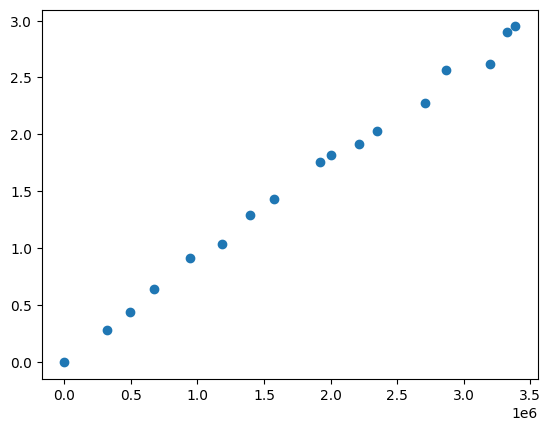

In [8]:
import matplotlib.pyplot as plt

def plot():
    x = [0, 322000, 493000, 673000, 943000, 1183000, 1393000, 1573000, 1921000, 2000000, 2210000, 2346000,
         2706000, 2870000, 3200000, 3328000, 3386000]
    y = [a / 1024 for a in [0, 292, 451, 660, 941, 1060, 1320, 1470, 1800, 1860, 1960, 2080, 2330, 2630, 2680, 2970, 3020]]

    plt.scatter(x, y)
    plt.show()

plot()

7. Porównanie wsparcia da popularnych jezyków programowania oraz próba określenia łatwości korzystania z dokumentacji i jej kompletności

Java jest jedynym językiem programowania, który jest bezpośrednio wspierany przez Solr. Niestety, mimo to dokumentacja bywa przestarzała - klasa `HttpSolrClient` jest już oznaczona jako deprecated, jednakże stanowi trzon przykładów użycia klienta.

Aby korzystać z innego języka programowania niż Java, można wykorzystać zapytania HTTP. Niestety, informacje o korzystaniu z nich są bardzo wybrakowane. Przykładowo, problemem było już samo zadeklarowanie struktury indeksowanych dokumentów, gdyż dokumentacja nigdzie nie specyfikuje dostępnych typów danych. Jedynym miejscem, w którym można je znaleźć, jest przykład użycia:

![solr](./images/solr1.png)